# MM: Bootstrap Estimation

In [1]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_functions_optSim import *
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial

In [2]:
planting(456)

In [3]:
# set system wide param
k = 7 # no. of states
timeCourse = 16 # total timepoints
u = [1] * int(timeCourse) # time interval
n_param = int(k/2 * (k-1)) # number of parameters

sampRange_ub = 10
xterm = 1e-15
max_iter = 1e4
numCores = 12
mc_iter = 25

In [4]:
startCount = 10**6 # no. in initial system
N0 = createN0(k, startCount, )
Q_true = make_theta0(k, 'Q')

# ingress into system & noise
simOpen_df = generateAggStates(N0, Q_true, (timeCourse - 1), u=u, recruit=True, timeCount=0, timeMarker='d', noise=True)
simOpen = simOpen_df.to_numpy()

## Closed Sysem

In [5]:
# set variables
N, M, T = eqTin(simOpen)

reg_bounds = def_bounds(n_param, k, account_ingress=False)
reg_con = def_constraints(n_param, k)

In [ ]:
# estimate
openNoise_theta, openNoise_optError = parallel_mc_optimiser(mc_iter, numCores, n_param, optimiserArgs = {'costFunc': calc_S1, 'args': (M, N, T, k, u), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': sampRange_ub}, options = {'hessian': None, 'xterm': xterm, 'max_iter': max_iter}, progress_bar=True)

In [ ]:
import pickle
filename = "manuscript_results/simData_Open.pkl"
with open(filename, 'wb') as f:
    pickle.dump([openNoise_theta, openNoise_optError], f)

In [7]:
import pickle
filename = "manuscript_results/simData_Open.pkl"
with open(filename, 'rb') as f:
    openNoise = pickle.load(f)

openNoise_theta = openNoise[0]
openNoise_optError = openNoise[1]

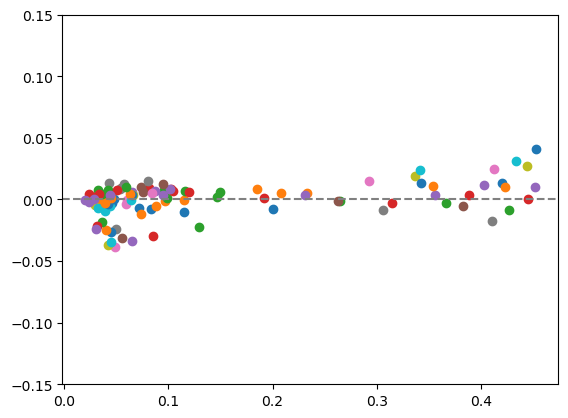

Average abs. residual:  0.009926836879815656


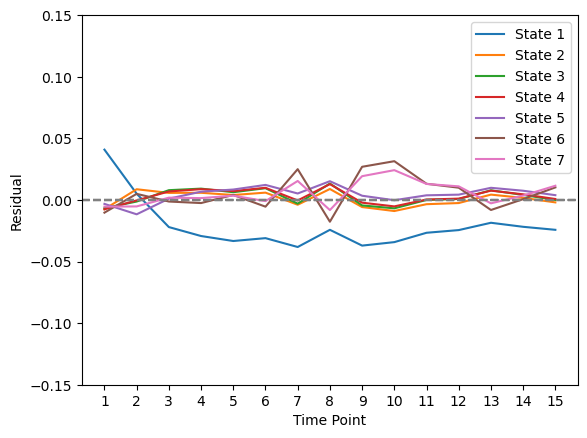

In [8]:
# residuals
new = openNoise_theta
S1_Q = theta_to_Q(new, k)

state_list = ['State ' + str(i) for i in range(1,k+1)]

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = pred[:,(i-1)] - N[:,i]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-.15,.15)
plt.show() 

xseq = []
for i in range(1,timeCourse): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = state_list[i]); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-.15,.15)
        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [9]:
pd.DataFrame(transMat(S1_Q, u[0]), index=state_list, columns=state_list)

,State 1,State 2,State 3,State 4,State 5,State 6,State 7
State 1,0.566419,0.063327,8.695216e-02,1.015864e-01,5.615404e-02,0.103494,0.022067
State 2,0.000000,0.767116,6.312818e-08,4.389793e-08,4.463578e-07,0.164555,0.068329
State 3,0.000000,0.000000,7.739037e-01,1.510669e-07,7.545189e-07,0.029689,0.196407
State 4,0.000000,0.000000,0.000000e+00,8.015585e-01,8.173018e-02,0.004912,0.111799
State 5,0.000000,0.000000,0.000000e+00,0.000000e+00,8.920254e-01,0.107032,0.000942
State 6,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.982923,0.017077
State 7,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000


In [10]:
# transform residual vector
Y = np.array([])
X = np.empty((0,2))

for t in range(T-1):
    Y = np.append(Y,epsi[t,:], axis=0)
    time = [t+1]*len(state_list)
    features = np.concatenate((np.array(time).reshape(7,1),np.array(state_list).reshape(7,1)), axis = 1)
    X = np.append(X,features, axis = 0)

df=pd.DataFrame(X, columns=('TimePoint','State'))
df.TimePoint = df.TimePoint.astype('int64')
df = pd.get_dummies(data=df, drop_first=True)
X = df


In [11]:
import statsmodels.api as sm
X = sm.add_constant(X)
X = X.astype('float')
ls=sm.OLS(Y,X).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     9.527
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           5.85e-09
Time:                        16:59:26   Log-Likelihood:                 327.88
No. Observations:                 105   AIC:                            -639.8
Df Residuals:                      97   BIC:                            -618.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0213      0.003     -6.095

### Error Estimation

We want to take bootstrap samples with replacement of the same size as the original. Then we will run our estimator, this will be repeated $B$ times. The estimate standard error will be: 

\begin{equation}
    \hat{se}_B = \sqrt{\frac{\sum_{b=1}^B \hat{\theta}(b) - \hat{\theta}^*}{B-1}}
\end{equation}

where $\hat{\theta}^* = \frac{\sum_{b=1}^B \hat{\theta}(b)}{B}$.

In [12]:
# number of bootstrap samples
B = 500

stateParam = {'state_col_name': 'State', 'numStates': k}
timeParam = {'timemarker': 'd', 'dayColumnName': 'Day', 'timeinterval': u}
mcArgs = {'mciter': mc_iter, 'n_cores': numCores}
optimiserArgs = {'costFunc': calc_S1, 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': sampRange_ub} 
options = {'xterm': xterm, 'max_iter': max_iter}

#### NP: Case Resample

In [13]:
sim_repertoire = pd.DataFrame({'State': [], 'Day': []})

for i in range(simOpen_df.shape[1]):
    day = simOpen_df.columns[i]
    
    day_count = simOpen_df[day]
    
    day_rep = pd.DataFrame({'State': [], 'Day': []})
    
    for j in range(7):
        state_rep = pd.DataFrame({'State':['State ' + str(j+1)], 'Day': day})
        day_rep = day_rep._append(int(day_count[j]) * [state_rep])
    
    sim_repertoire = pd.concat([sim_repertoire,day_rep])

In [14]:
caseResamp = bootstrap_caseResamp(sim_repertoire, B, timeParam, n_param, make_theta0, stateParam, state_list, mcArgs, optimiserArgs, options)
caseResamp['theta_est'] = openNoise_theta

In [ ]:
import pickle 
# pickling
filename = "manuscript_results/simData_Open_bootstrap.pkl"
with open(filename, 'wb') as f:
    pickle.dump([caseResamp], f)

#### Resample residuals

In [ ]:
residResamp = bootstrap_resResamp(simOpen, u, B, n_param, make_theta0, mcArgs, optimiserArgs, options)

Point estimate calculation ...


Optimisation progress:  [================================================] 100%
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv


In [ ]:
# pickling
filename = "manuscript_results/simData_Open_bootstrap.pkl"
with open(filename, 'wb') as f:
    pickle.dump([caseResamp,residResamp], f)

### Parametric

In [ ]:
parametric = bootstrap_parametric(simOpen, u, B, n_param, make_theta0, mcArgs, optimiserArgs, options)

0.020121136376851542834
BS iteration: 2
7.507461407831067333e-11
BS iteration: 3
2.333555479034993281e-12
BS iteration: 4
0.3514477751617188742
BS iteration: 5
5.5438051615654054153e-12
BS iteration: 6
5.1670275879053607466e-12
BS iteration: 7
6.960527864772926246e-12
BS iteration: 8
2.9722183479354509808e-12
BS iteration: 9
5.575330782511579456e-12
BS iteration: 10
4.2311819836309678544e-12
BS iteration: 11
6.4958831535414224315e-12
BS iteration: 12
7.051215069785705377e-12
BS iteration: 13
5.0350434999074966016e-12
BS iteration: 14
7.540492564469683849e-12
BS iteration: 15
3.74567424183028935e-12
BS iteration: 16
5.8632491523532812588e-12
BS iteration: 17
5.9653917540041877815e-12
BS iteration: 18
4.096557665834309538e-12
BS iteration: 19
4.0903866574417897635e-12
BS iteration: 20
3.4420756207070901348e-12
BS iteration: 21
2.6098269274090637476e-12
BS iteration: 22
3.928139023617805876e-12
BS iteration: 23
4.3106384228579828288e-12
BS iteration: 24
5.728571084044671928e-12
BS iterati

In [ ]:
# pickling
filename = "manuscript_results/simData_Open_bootstrap.pkl"
with open(filename, 'wb') as f:
    pickle.dump([caseResamp,residResamp, parametric], f)

Visualise Error

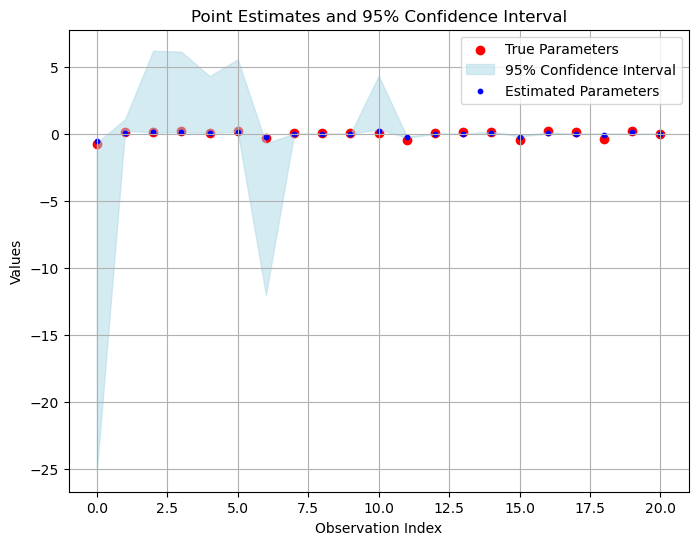

In [ ]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the  true values
plt.scatter(x=np.arange(n_param),y=Q_true[np.nonzero(Q_true[:,:-1])], color='red', label='True Parameters')

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(caseResamp['theta_est'])), y1=caseResamp['confidenceInterval'][0], y2=caseResamp['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=caseResamp['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

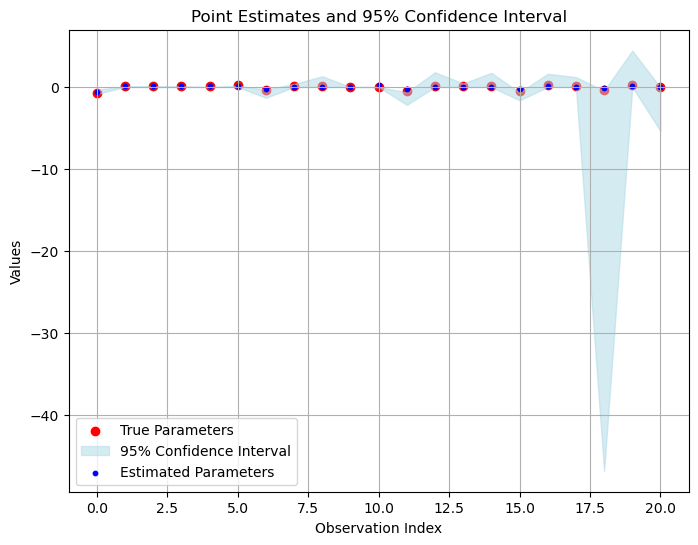

In [ ]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the  true values
plt.scatter(x=np.arange(n_param),y=Q_true[np.nonzero(Q_true[:,:-1])], color='red', label='True Parameters')

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(residResamp['theta_est'])), y1=residResamp['confidenceInterval'][0], y2=residResamp['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=residResamp['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

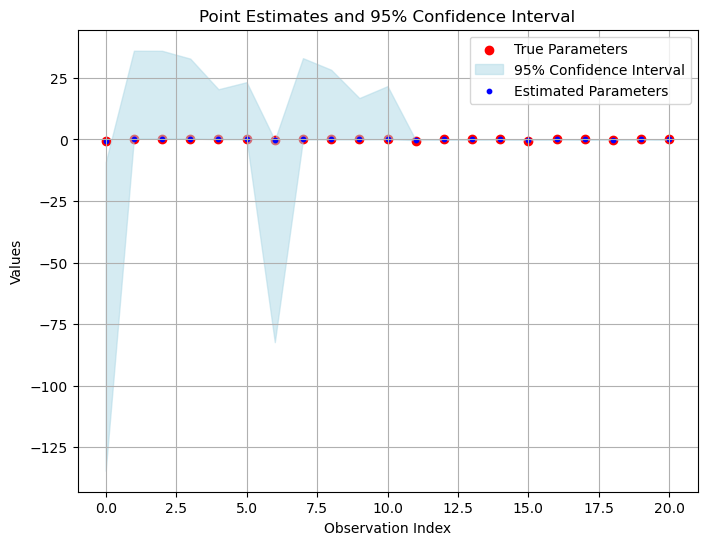

In [ ]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the  true values
plt.scatter(x=np.arange(n_param),y=Q_true[np.nonzero(Q_true[:,:-1])], color='red', label='True Parameters')

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(parametric['theta_est'])), y1=parametric['confidenceInterval'][0], y2=parametric['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=parametric['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

### Number of Bootstrap Samples

In [10]:
# pickling
import pickle
filename = "manuscript_results/simData_Open_bootstrap.pkl"
with open(filename, 'rb') as f:
    caseResamp,residResamp, parametric = pickle.load(f)

UnsupportedOperation: read

In [ ]:
N_boot = len(caseResamp['bootEstimates'])

# Create a plot
plt.figure(figsize=(8, 6))

# x-axis
xaxis = np.linspace(1, N_boot, N_boot)
for p in range(n_param):
    param_boot = np.zeros(N_boot)
    mean_boot = np.zeros(N_boot)
    for b in range(N_boot):
        param_boot[b] = caseResamp['bootEstimates'][b][p]
        mean_boot[b] = np.mean(param_boot[:b])
    plt.plot(xaxis,mean_boot)
plt.show()

In [ ]:
N_boot = len(residResamp['bootEstimates'])

# Create a plot
plt.figure(figsize=(8, 6))

# x-axis
xaxis = np.linspace(1, N_boot, N_boot)
for p in range(n_param):
    param_boot = np.zeros(N_boot)
    mean_boot = np.zeros(N_boot)
    for b in range(N_boot):
        param_boot[b] = residResamp['bootEstimates'][b][p]
        mean_boot[b] = np.mean(param_boot[:b])
    plt.plot(xaxis,mean_boot)
plt.show()

In [ ]:
N_boot = len(parametric['bootEstimates'])

# Create a plot
plt.figure(figsize=(8, 6))

# x-axis
xaxis = np.linspace(1, N_boot, N_boot)
for p in range(n_param):
    param_boot = np.zeros(N_boot)
    mean_boot = np.zeros(N_boot)
    for b in range(N_boot):
        param_boot[b] = parametric['bootEstimates'][b][p]
        mean_boot[b] = np.mean(param_boot[:b])
    plt.plot(xaxis,mean_boot)
plt.show()